<a href="https://colab.research.google.com/github/connorj4/CNN-plant-subkingdom/blob/master/Plant_Classification_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.0.1.post2
Torchvision Version:  0.2.2


In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

net = torchvision.models.vgg19(pretrained='imagenet') #vgg 19 layers trained on imagenet

n_class = 5 #number of output classes (used in the final layer we add to train)

num_ftrs = net.classifier[6].in_features #get the input to the last layer

features = list(net.classifier.children())[:-1] #get all layers other than the last one (bc we are replacing it)

features.extend([nn.Linear(num_ftrs, n_class)]) #add a final layer with output as number of classes

net.classifier = nn.Sequential(*features) #wrap in sequential ocntainer. add back to model.

print(net) #get architecture

for p in net.parameters():
  p.requires_grad = False

for p in net.classifier.parameters():
  p.requires_grad = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if(device=="cpu"):
  print("nogpu")
  raise
  
net.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
574673361it [00:12, 45268251.66it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls '/content/gdrive/My Drive' #if dataset is not here may need to debug!!

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
 001.gsheet
 classExample
 CNN.ipynb
'Colab Notebooks'
'CollegeCraft Pres 2.gslides'
 CSC555.gslides
'CSC563 Notes.pdf'
'CSC563 Pres2.gslides'
 dataset
 datasets
 dataset_sm
 dataset_sqr
 dist_Flickr_image_downloaders.ipynb
 faces
 foo.txt
'General presentation.gslides'
'G.Michael Schneider, Judith Gersting-Invitation to Computer Science-Course Technology (2015) (1).pdf'
'G.Michael Schneider, Judith Gersting-Invitation to Computer Science-Course Technology (2

['angiosperms', 'gymnosperms', 'modern green algae', 'seedless non-vascular', 'seedless vascular']
['angiosperms', 'gymnosperms', 'modern green algae', 'seedless non-vascular', 'seedless vascular']
tensor([3, 2, 2, 3, 2, 3, 1, 3, 3, 0, 1, 4, 2, 4, 2, 0])
torch.Size([16, 3, 224, 224])
seedless non-vascular


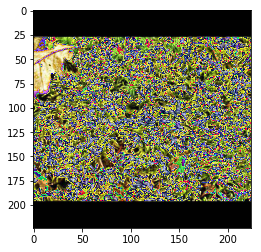

In [4]:
transform = transforms.Compose(
    [transforms.Resize(224), #VGG19 input size
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #mean .5, stddev .5

imagenet_data_train = torchvision.datasets.ImageFolder('/content/gdrive/My Drive/dataset_sm/train',transform=transform)
print(imagenet_data_train.classes) #our 5 classes
imagenet_data_test = torchvision.datasets.ImageFolder('/content/gdrive/My Drive/dataset_sm/test',transform=transform)
print(imagenet_data_test.classes) #our 5 classes

#dataloader will assist us in using minibatch i.e. SGD
batch_size = 16
data_loader_train = torch.utils.data.DataLoader(imagenet_data_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)
data_loader_test = torch.utils.data.DataLoader(imagenet_data_test,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)
try: #this is to suppress a weird error
  x = iter(data_loader_train)
except:
  print("")
img, label = x.next()
print(label) # should be 16 labels between 0 and 4
print(img.size()) #should be 4D [minibatchsize, chan, len, wid]
from PIL import Image
from matplotlib import pyplot as plt
plt.imshow(transforms.functional.to_pil_image(img[0])) #first image in the minibatch
classes = imagenet_data_test.classes
print(classes[label[0]]) #first label of the 16


In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(list(filter(lambda p: p.requires_grad, net.parameters())), lr=.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1, last_epoch=-1)
for p in net.parameters():
  print(p.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True


In [14]:
#professor code !! (mostly)
start = time.time()
for p in net.parameters():
  print(p.requires_grad)

for epoch in range(4):  # loop over the dataset multiple times
    scheduler.step()
    running_loss = 0.0
    for i, data in enumerate(data_loader_train, 0): #grab a minibatch
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) #since network is on GPU move the inputs and labels to GPU

        # zero the parameter gradients
        optimizer.zero_grad() #dont use old gradients
        
        # forward + backward + optimize
        outputs = net(inputs)  #net.forward(inputs)
        loss = criterion(outputs, labels) 
        loss.backward()
        optimizer.step() #uses SGD

        # print statistics
        running_loss += loss.item()
        #print(loss.item())
        #print(outputs)
        #print(labels)
        if i % 2 == 1:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2))
            running_loss = 0.0
end = time.time()
print(end - start)
print('Finished Training')

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
[1,     2] loss: 0.301
[1,     4] loss: 0.489
[1,     6] loss: 0.573
[1,     8] loss: 0.471
[1,    10] loss: 0.420
[1,    12] loss: 0.638
[1,    14] loss: 0.420
[1,    16] loss: 0.502
[1,    18] loss: 0.406
[1,    20] loss: 0.542
[1,    22] loss: 0.599
[1,    24] loss: 0.624
[1,    26] loss: 0.545
[1,    28] loss: 0.544
[1,    30] loss: 0.338
[1,    32] loss: 0.569
[1,    34] loss: 0.338
[1,    36] loss: 0.430
[1,    38] loss: 0.473
[1,    40] loss: 0.480
[1,    42] loss: 0.482
[1,    44] loss: 0.367
[1,    46] loss: 0.438
[1,    48] loss: 0.504
[1,    50] loss: 0.446
[1,    52] loss: 0.654
[1,    54] loss: 0.437
[1,    56] loss: 0.697
[1,    58] loss: 0.395
[1,    60] loss: 0.267
[1,    62] loss: 0.410
[1,    64] loss: 0.516
[1,    66] loss: 0.603
[1,    68] loss: 0.

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken p

KeyboardInterrupt: ignored

In [0]:
torch.save(net.state_dict(),'/content/gdrive/My Drive/plantClassificationWeights.pth') #save and run md5 to make sure not going crazy...

In [16]:
start = time.time()
print("hello")
total = 0
correct = 0
with torch.no_grad():
    for data in data_loader_test:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
print("total of")
print(total)
end = time.time()
#print(end - start)

class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))
with torch.no_grad():
    for data in data_loader_test:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(5):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

hello
Accuracy of the network on the test images: 72 %
total of
150
Accuracy of angiosperms : 66 %
Accuracy of gymnosperms : 85 %
Accuracy of modern green algae : 85 %
Accuracy of seedless non-vascular : 50 %
Accuracy of seedless vascular : 55 %


from google.colab import drive
drive.mount('/content/gdrive')
modern CNN architecture resnet
